# Wheat Detection:

In [ ]:
! pip install albumentations==0.4.6

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm as tqdm

import cv2
import os
import re

import random

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
import ast
import time

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

In [3]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Mounted at /gdrive/
MyDrive  Shareddrives


In [5]:
INPUT_DATA = "/gdrive/My Drive/global-wheat-detection/"
TRAIN_DIR = os.path.join(INPUT_DATA, "train")
TEST_DIR = os.path.join(INPUT_DATA, "test")

In [6]:
df = pd.read_csv(os.path.join(INPUT_DATA, "train.csv"))
df.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [61]:
##Unique Images 
print(f'Unique Images in train DataFrame: {len(df["image_id"].value_counts())}')

Unique Images in train DataFrame: 3373


In [9]:
## Extract x,y,w,h from bbox
def extract_bbox(DataFrame):
    DataFrame["x"] = [np.float(ast.literal_eval(i)[0]) for i in DataFrame["bbox"]]
    DataFrame["y"]=  [np.float(ast.literal_eval(i)[1]) for i in DataFrame["bbox"]]
    DataFrame["w"] = [np.float(ast.literal_eval(i)[2]) for i in DataFrame["bbox"]]
    DataFrame["h"] = [np.float(ast.literal_eval(i)[3]) for i in DataFrame["bbox"]]

In [10]:
extract_bbox(df)
df.head()

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


# Train Valid Split:

In [11]:
images_id = df["image_id"].unique()
total_len = len(images_id)
train_ratio = 0.8
train_len = int(len(images_id)*train_ratio)

train_idxs = random.sample(range(total_len), train_len)
valid_idxs = np.delete(np.array(range(total_len)), train_idxs)

train_ids = images_id[train_idxs]
valid_ids = images_id[valid_idxs]

print(f"Total Images Number: {len(images_id)}")
print(f"Number of training images: {len(train_ids)}")
print(f"Number of Valid images: {len(valid_ids)}")

Total Images Number: 3373
Number of training images: 2698
Number of Valid images: 675


In [62]:
train_df = df[df["image_id"].isin(train_ids)]
valid_df = df[df["image_id"].isin(valid_ids)]

In [13]:
# Data Transform - Albumentation
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [14]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        super().__init__()
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = dataframe["image_id"].unique()
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        details = self.dataframe[self.dataframe["image_id"]==image_id]
        img_path = os.path.join(TRAIN_DIR, image_id)+".jpg"
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Row of Dataframe of a particular index.
        boxes = details[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        #To find area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        #COnvert it into tensor dataType
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((details.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((details.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx) ### <------------ New change list has been removed
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            
            sample = self.transform(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.long)
        
        return image, target     #, image_id
    
    def __len__(self) -> int:
        return len(self.image_ids)

# Load Datasets

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_dataset = WheatDataset(train_df, TRAIN_DIR, get_train_transform())
valid_dataset = WheatDataset(valid_df, TRAIN_DIR, get_valid_transform())

print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of test_dataset: {len(valid_dataset)}")

Length of train_dataset: 2698
Length of test_dataset: 675


In [17]:
##DataLoader
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Visualize Training Images

In [29]:
#PLot images
def plot_images(n_num, random_selection=True):
    '''Function to visualize N Number of images'''
    if random_selection:
        index = random.sample(range(0, len(train_df["image_id"].unique())-1), n_num)
    else:
        index = range(0, n_num)
    plt.figure(figsize=(10,10))
    fig_no = 1
    
    for i in index:
        images, targets = train_dataset.__getitem__(i)
        sample = np.array(np.transpose(images, (1,2,0)))
        boxes = targets["boxes"].numpy().astype(np.int32)
    
        #Plot figure/image

        for box in boxes:
            cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(255,223,0), 2)
        plt.subplot(n_num/2, n_num/2, fig_no)
        plt.imshow(sample)
        fig_no+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


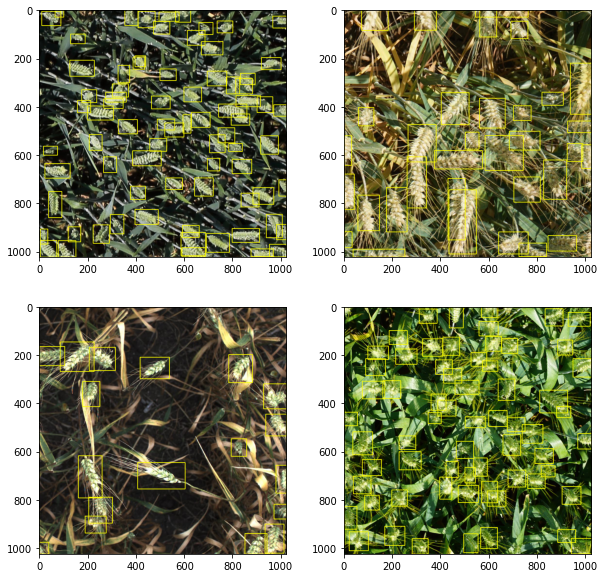

In [30]:
plot_images(4)

# Create Model

In [20]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [21]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 8

In [23]:
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

Version 1.7.0+cu101
CUDA enabled: True


In [24]:
total_train_loss = []
total_valid_loss = []

losses_value = 0
for epoch in range(num_epochs):
  
    start_time = time.time()
    train_loss = []
    model.train()
    
    # -----------Training Loop----------------------------
    for images, targets in pbar:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        losses_value = losses.item()
        train_loss.append(losses_value)        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    
    
    # ---------------Validation Loop----------------------
    with torch.no_grad():
        valid_loss = []

        for images, targets in valid_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # If you need validation losses
            model.train()
            # Calculate validation losses
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            valid_loss.append(loss_value)
            
    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)
    
    print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time},\
    Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}") 


Epoch Completed: 1/8, Time: 666.8710315227509,    Train Loss: 0.9563933663819668, Valid Loss: 1.1592834802234875



Epoch Completed: 2/8, Time: 664.7394649982452,    Train Loss: 0.8477578473514353, Valid Loss: 1.0617056390818427



Epoch Completed: 3/8, Time: 664.1669037342072,    Train Loss: 0.8187071609602877, Valid Loss: 1.0590220374219559



Epoch Completed: 4/8, Time: 665.145298242569,    Train Loss: 0.7990766338695435, Valid Loss: 1.0514441048397738



Epoch Completed: 5/8, Time: 665.7199430465698,    Train Loss: 0.7838177888174734, Valid Loss: 1.0384846918723163



Epoch Completed: 6/8, Time: 665.6182889938354,    Train Loss: 0.776630797329739, Valid Loss: 1.0482578817535848



Epoch Completed: 7/8, Time: 665.0245261192322,    Train Loss: 0.7690508295093063, Valid Loss: 0.9894845520748812



Epoch Completed: 8/8, Time: 665.5503387451172,    Train Loss: 0.7616734152009501, Valid Loss: 1.004276558230905


# Plot Train, Valid losses

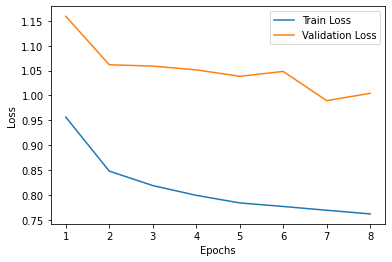

In [57]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8]
loss = [total_train_loss, total_valid_loss]
labels = ["Train Loss", "Validation Loss"]

for arr, label in zip(loss, labels):
    plt.plot(epochs, arr, label=label)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Testing

In [32]:
# Data Transform - Test Albumentation
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [33]:
class WheatTestDatasetTest(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        super().__init__()
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = dataframe["image_id"].unique()
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        #details = self.dataframe[self.dataframe["image_id"]==image_id]
        img_path = os.path.join(TEST_DIR, image_id)+".jpg"
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transform:
            sample = {
                'image': image,
            }
            
            sample = self.transform(**sample)
            image = sample['image']
        
        return image, image_id
    
    def __len__(self) -> int:
        return len(self.image_ids)

# Load Test Dataset

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDatasetTest(df_test, TEST_DIR, get_test_transform())
print(f"Length of test dataset: {len(test_dataset)}")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

Length of test dataset: 10


# Evaluate Model

In [63]:
model.eval()
x = model.to(device)

In [64]:
detection_threshold = 0.5
output_list = []


for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        output_dict = {
            'image_id': image_ids[i],
            'boxes': outputs[i]['boxes'].data.cpu().numpy(),
            'scores': outputs[i]['scores'].data.cpu().numpy()
        }
        output_list.append(output_dict)

# Predict Images

In [65]:
## Plot image prediction

def predict_images(n_num, random_selection=True):
    '''Plot N Number of Predicted Images'''
    if random_selection:
        index = random.sample(range(0, len(df_test["image_id"].unique())), n_num)
    else:
        index = range(0, n_num)
        
    plt.figure(figsize=(15,15))
    fig_no = 1
    
    for i in index:
        images, image_id = test_dataset.__getitem__(i)
        sample = images.permute(1,2,0).cpu().numpy()
        boxes = output_list[i]['boxes']
        scores = output_list[i]['scores']
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        #Plot figure/image
        for box in boxes:
            cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(255,223,0), 2)
        plt.subplot(n_num/2, n_num/2, fig_no)
        plt.imshow(sample)
        fig_no+=1

In [66]:
def print_image(i):
  plt.figure(figsize=(6,6))
  images, image_id = test_dataset.__getitem__(i)
  sample = images.permute(1,2,0).cpu().numpy()
  boxes = output_list[i]['boxes']
  scores = output_list[i]['scores']
  boxes = boxes[scores >= detection_threshold].astype(np.int32)
  #Plot figure/image
  for box in boxes:
      cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(255,223,0), 2)
  # plt.subplot(n_num/2, n_num/2, fig_no)
  plt.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


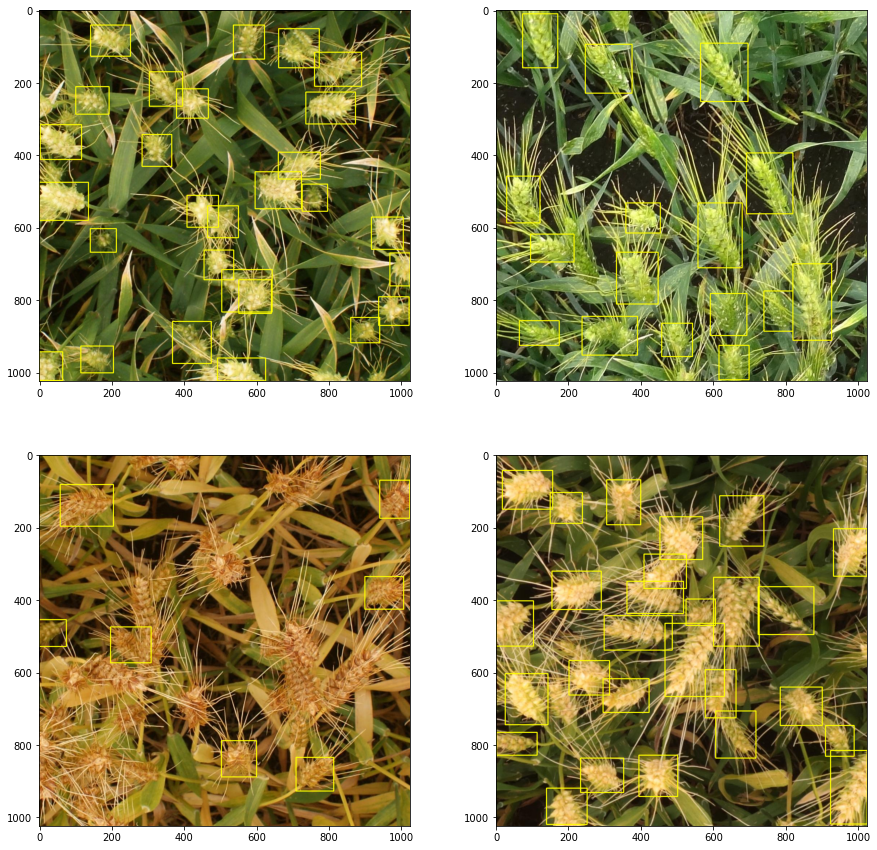

In [67]:
predict_images(4, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


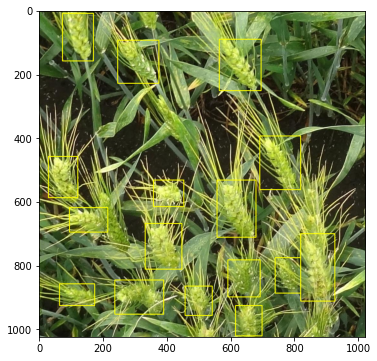

In [68]:
print_image(0)